In [1]:
# modified from https://github.com/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Try UnSAMv2 to segment all instances in images at any granularity!

## Set-up

In [2]:
import os
import logging
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

logging.basicConfig(level=logging.INFO)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


In [ ]:
np.random.seed(94704) # :D

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [5]:
# Optional CascadePSP post-processing built on cascadepsp.py
from contextlib import nullcontext

USE_CASCADE_PSP = True  # Toggle to enable or disable CascadePSP refinement

try:
    import segmentation_refinement as refine
except ImportError:
    refine = None
    logging.warning("segmentation_refinement is not installed; disabling CascadePSP post-processing.")

try:
    from cascadepsp import postprocess
    from pycocotools import mask as mask_util
except ImportError as exc:
    postprocess = None
    mask_util = None
    logging.warning(f"CascadePSP dependencies missing ({exc}); disabling post-processing.")

refiner = None
if USE_CASCADE_PSP:
    if refine is None or postprocess is None or mask_util is None:
        USE_CASCADE_PSP = False
    elif device.type != "cuda":
        logging.warning("CascadePSP refiner requires CUDA; using raw masks instead.")
        USE_CASCADE_PSP = False
    else:
        try:
            current_cuda = torch.cuda.current_device()
            refiner = refine.Refiner(device=f"cuda:{current_cuda}")
            logging.info("CascadePSP refiner initialized on cuda:%d", current_cuda)
        except Exception as exc:
            logging.error("Failed to initialize CascadePSP refiner: %s", exc)
            USE_CASCADE_PSP = False

class CascadePSPArgs:
    def __init__(self):
        self.crop_ratio = 2.0
        self.refine_scale = 1
        self.refine_min_L = 100
        self.refine_max_L = 900
        self.iou_thresh = 0.5
        self.min_area_thresh = 0.0
        self.max_area_thresh = 0.9
        self.cover_thresh = 0.9

cascadepsp_args = CascadePSPArgs()

def _ensure_uint8_numpy(image):
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().to(torch.uint8).numpy()
    elif not isinstance(image, np.ndarray):
        image = np.array(image)
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    return image

def apply_cascadepsp(masks, image, enable=True):
    if not masks or not enable:
        return masks
    if refiner is None:
        logging.warning("CascadePSP requested but refiner is not available; returning original masks.")
        return masks
    safe_image = _ensure_uint8_numpy(image)
    logging.info("Applying CascadePSP post-processing to %d masks", len(masks))
    try:
        annotations = {"annotations": []}
        for i, mask_data in enumerate(masks):
            mask = mask_data['segmentation']
            if not isinstance(mask, np.ndarray):
                mask = np.array(mask)
            mask = mask.astype(np.uint8)
            encoded_mask = mask_util.encode(np.asfortranarray(mask))
            encoded_mask['counts'] = encoded_mask['counts'].decode('ascii')

            annotation = {
                'id': i,
                'segmentation': encoded_mask,
                'bbox': mask_data.get('bbox'),
                'area': mask_data.get('area'),
                'predicted_iou': mask_data.get('predicted_iou', 0.0),
                'stability_score': mask_data.get('stability_score', 0.0)
            }
            annotations["annotations"].append(annotation)

        autocast_ctx = torch.autocast(device_type='cuda', dtype=torch.bfloat16, enabled=False) if device.type == 'cuda' else nullcontext()
        with autocast_ctx:
            refined_annotations = postprocess(cascadepsp_args, refiner, annotations, safe_image)

        refined_masks = []
        for annotation in refined_annotations["annotations"]:
            refined_mask = mask_util.decode(annotation['segmentation'])

            mask_entry = {
                'segmentation': refined_mask.astype(bool),
                'area': annotation.get('area'),
                'bbox': annotation.get('bbox'),
                'predicted_iou': annotation.get('predicted_iou', 0.0),
                'stability_score': annotation.get('stability_score', 0.0),
                'point_coords': [[
                    annotation['bbox'][0] + annotation['bbox'][2]/2,
                    annotation['bbox'][1] + annotation['bbox'][3]/2
                ]]
            }
            refined_masks.append(mask_entry)

        logging.info(f"Post-processing completed: {len(masks)} -> {len(refined_masks)} masks")
        return refined_masks
    except Exception as exc:
        logging.error(f"Post-processing failed: {exc}, returning original masks")
        return masks


/home/yujunwei/anaconda3/envs/UnSAMv2/lib/python3.10/site-packages/segmentation_refinement/main.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(

## Raw image

In [6]:
image = Image.open('images/sa_291195.jpg')
image = np.array(image.convert("RGB"))

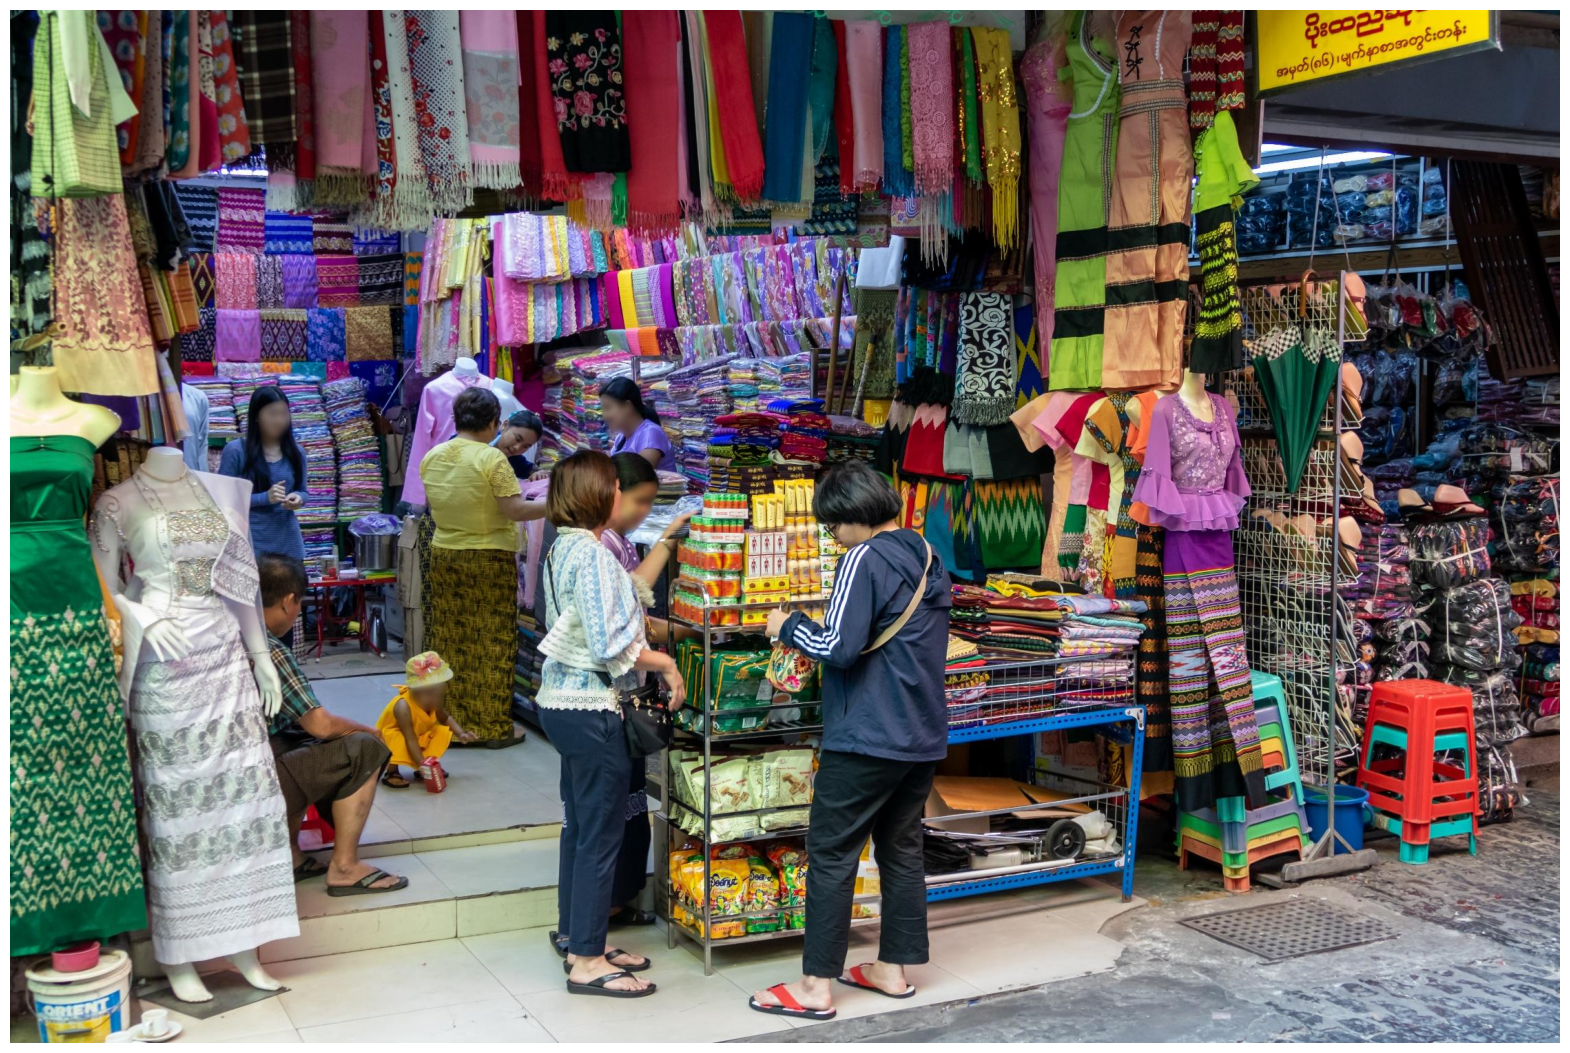

In [7]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()


## Inference for whole image segmentation

In [ ]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/unsamv2_plus_ckpt.pt"
model_cfg = "configs/unsamv2_small.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=True)

# worth to try different combinations of pred_iou_thresh and stability_score_thresh

mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    mask_threshold=-1,
    pred_iou_thresh=0.77,
    stability_score_thresh=0.9,
    stability_score_offset=0.7,
    crop_n_layers=0,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=0,
    use_m2m=True,
)

INFO:root:Loaded checkpoint sucessfully
INFO:root:Setting up LoRA after loading pretrained weights...
INFO:root:Loaded 56 LoRA tensors from checkpoint.


Applying LoRA to UnSAMv2...
Successfully applied LoRA to UnSAMv2.


In [10]:
raw_masks = mask_generator.generate(image, gra=0.15)
masks = apply_cascadepsp(raw_masks, image, enable=USE_CASCADE_PSP)

INFO:root:For numpy array image, we assume (HxWxC) format
INFO:root:Computing image embeddings for the provided image...
INFO:root:Image embeddings computed.
INFO:root:Applying CascadePSP post-processing to 609 masks
INFO:root:Post-processing completed: 609 -> 609 masks


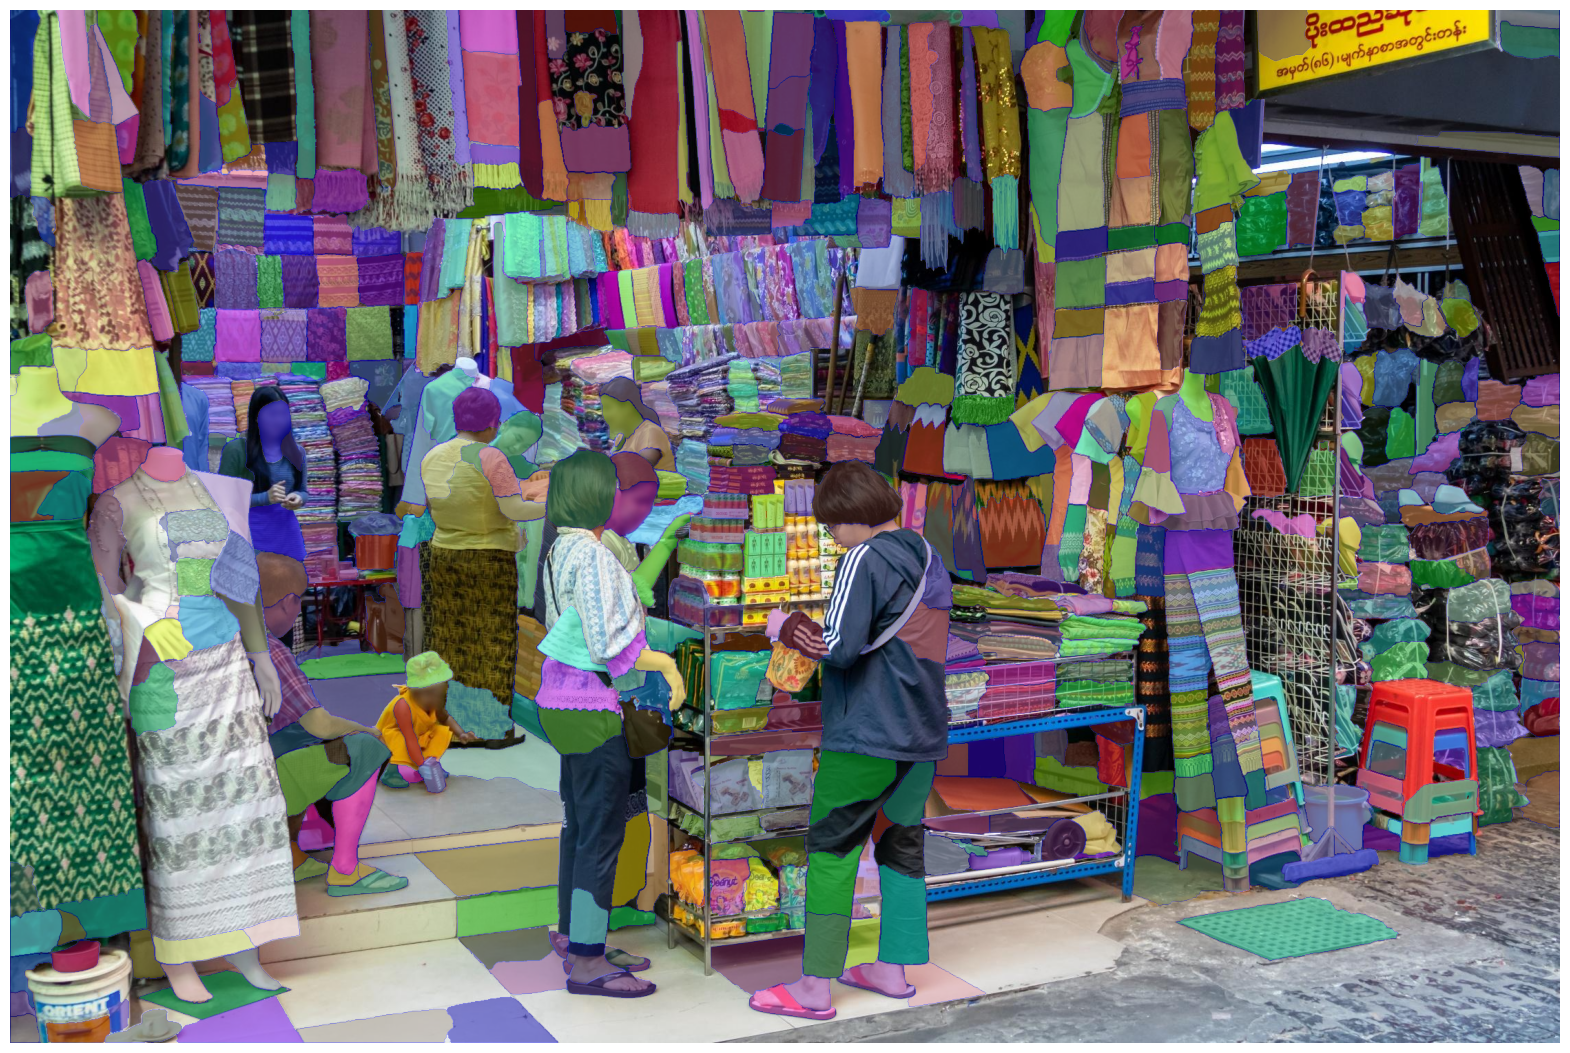

In [11]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 